In [1]:
# Basic data manipulation
import pandas as pd
import numpy as np
import joblib
import os
import json

# Data visualization
import matplotlib.pyplot as plt
# Plotting Predicted vs Actual values
def plot_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def plot_predicted_vs_actual_with_jitter(y_true, y_pred, jitter_amount=0.02):
    # Adding jitter: add normally distributed noise to both y_true and y_pred
    jitter_y_true = y_true + np.random.normal(0, jitter_amount, y_true.shape)
    jitter_y_pred = y_pred + np.random.normal(0, jitter_amount, y_pred.shape)

    plt.figure(figsize=(10, 6))
    plt.scatter(jitter_y_true, jitter_y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual Values with Jitter')
    plt.grid(True)
    plt.show()

# models
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score



# Data preprocessing
# from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Model evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    confusion_matrix
)


def custom_accuracy_within_one_class(y_true, y_pred):
    correct = np.sum(np.abs(y_true - y_pred) <= 1)
    total = len(y_true)
    return correct / total


def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a simple confusion matrix with minimal configuration.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()  # Adds a colorbar to show the scale
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def plot_confusion_matrix_with_histograms(y_true, y_pred):
    """
    Plots a confusion matrix with histograms for true and predicted label distributions.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    
    # Create the main figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Positioning of the main confusion matrix plot
    main_ax = plt.subplot2grid((num_classes+1, num_classes+1), (1, 0), colspan=num_classes, rowspan=num_classes)
    main_ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Plot the histograms for the rows (True Labels)
    for i in range(num_classes):
        ax_row_hist = plt.subplot2grid((num_classes+1, num_classes+1), (1+i, num_classes))
        ax_row_hist.barh([0], [np.sum(cm[i, :])], color="blue", align='center')
        ax_row_hist.set_xlim(0, np.max(np.sum(cm, axis=1)) * 1.1)  # slightly larger to accommodate all bars
        ax_row_hist.set_yticks([])
        ax_row_hist.set_xticks([])

    # Plot the histograms for the columns (Predicted Labels)
    for j in range(num_classes):
        ax_col_hist = plt.subplot2grid((num_classes+1, num_classes+1), (num_classes, j))
        ax_col_hist.bar([0], [np.sum(cm[:, j])], color="blue", align='center')
        ax_col_hist.set_ylim(0, np.max(np.sum(cm, axis=0)) * 1.1)  # slightly larger to accommodate all bars
        ax_col_hist.set_xticks([])
        ax_col_hist.set_yticks([])

    # Labeling and showing the plot
    main_ax.set_title('Confusion Matrix with Histograms')
    main_ax.set_xlabel('Predicted label')
    main_ax.set_ylabel('True label')
    plt.tight_layout()
    plt.show()


def classify_linear_probability(data):
    # Calculate mean and standard deviation
    mean = data.mean()
    std = data.std()
    
    # Define cutoffs based on your specification
    cutoffs = [
        mean - 2 * std,
        mean - 1.5 * std,
        mean - std,
        mean - (1/3) * std,
        mean + (1/3) * std,
        mean + std,
        mean + 1.5 * std,
        mean + 2 * std
    ]
    
    # Use pandas.cut to categorize the data
    categories = pd.cut(data, bins=[-np.inf] + cutoffs + [np.inf], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])    


    return categories.codes

def get_model_performance(y,y_pred, plot = False):

    if isinstance(y, pd.core.frame.DataFrame):
        y = y.to_numpy()

    if isinstance(y_pred, pd.core.frame.DataFrame):
        y_pred = y_pred.to_numpy()

    rmse = np.sqrt(root_mean_squared_error(y, y_pred))
    r_2 = r2_score(y, y_pred)
    within_1 = custom_accuracy_within_one_class(y, y_pred)


    def acc(y, y_pred):
        accuracy = accuracy_score(y, y_pred)
        return accuracy


    accuracy = acc(y, y_pred)

    # print("Mean Absolute Error (MAE):", mean_absolute_error(y_train, y_pred_train))
    # print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_pred_train))

    print("Root Mean Squared Error (RMSE):", rmse)
    print("Accuracy:", accuracy)
    print("Within 1:", within_1)

    if plot:
        try:
            plot_confusion_matrix_with_histograms(y, y_pred)
        except ValueError:
            plot_predicted_vs_actual(y,y_pred)

    return rmse, r_2, within_1
    

In [ ]:
from rural_beauty.config import models_dir
import importlib

module_name = "rural_beauty.config"
para_outcome = 'beauty'
para_type = 'randomforest'
sugar    =  '111124'  # random identifier to have different models with same other paras
country = 'DE'


model_basename = f"{country}_{para_outcome}_{para_type}_{sugar}"

if not os.path.exists(models_dir / model_basename):
    os.mkdir(models_dir / model_basename)

# Import the module
config_module = importlib.import_module(module_name)

# Dynamically construct the variable name
feature_paths   = getattr(config_module, f"feature_paths_{country}")
BFN_features    = getattr(config_module, f"BFN_features_{para_outcome}")
predictors_path = getattr(config_module, f"predictors_{country}")
outcome_path    = getattr(config_module, f"outcome_{country}")
significant_coefs_path = models_dir / model_basename / "significant_coefs.csv"



This is the rural_beauty module


PosixPath('/h/u145/hofer/MyDocuments/Granular/beauty/data/models/DE_beauty_randomforest_111124/significant_coefs.csv')

enable %%R cells in the notebook (mostly for vizualisation)

In [3]:
# Load the features paths dict
with open(feature_paths, "r") as f:
    features = json.load(f)


predictors_all = pd.read_csv(predictors_path, sep=",",  index_col=False, na_values = -99)

predictors = predictors_all

if 'hemero_1' in predictors.columns:
    predictors = predictors.drop('hemero_1', axis = 1)

predictors.tail(5)

,dem_1,dem_2,dem_3,seemee_1,wald_1,natgru_2,obst_1_4,stoer_1_2,stra_1_2,acker_1_4,...,geholz_1,strauc_1,moor_1,dorf_1,indgew_1,gewae_1,obst_1,mwald_1,meer_1,semage_1
5010,0.010232,0.010274,0.009072,0.0,0.0,0.0,0.0,0.563936,0.065297,0.595203,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5011,0.011569,0.009159,0.010685,0.0,0.0,0.0,0.0,0.813629,0.008546,0.219882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5012,0.005943,0.005143,0.006602,0.0,0.0,0.0,0.0,0.699017,0.051293,0.312095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5013,0.031490,0.024523,0.017165,0.0,0.0,0.0,0.0,1.000000,0.000000,0.092771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5014,0.007142,0.008121,0.011197,0.0,0.0,0.0,0.0,0.548811,0.015051,0.488647,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now the left hand side

In [4]:
outcome = pd.read_csv(outcome_path, sep=",",  index_col=False, na_values = -99)
outcome = outcome[para_outcome].to_frame()
outcome.tail(5)

,beauty
5010,1
5011,1
5012,1
5013,1
5014,1


Split the Dataset

In [5]:
X    = predictors
Y    = outcome
feat = predictors.columns.values
print(X.shape)
print(Y.shape)

(5015, 67)
(5015, 1)


In [6]:
# Find rows with NaN values in X
na_rows_X = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
resultx = np.where(na_rows_X)[0]

# Find rows with NaN values or values outside the rante in Y
na_rows_Y = Y.apply(lambda x: np.any(pd.isna(x)) or np.any((x < 1) | (x > 9)), axis=1)
resulty = np.where(na_rows_Y)[0]

# Combine the results
result = list(set(resulty).union(set(resultx)))

print('NA rows: ' + str(result))

NA rows: [np.int64(1186), np.int64(1445), np.int64(487), np.int64(4711), np.int64(2444), np.int64(2416), np.int64(1299), np.int64(1140), np.int64(1975), np.int64(4475), np.int64(542), np.int64(1087)]


In [7]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])

print(X.shape)
print(Y.shape)

(5003, 67)
(5003, 1)


In [8]:
# from float to classes
Y[para_outcome] = Y[para_outcome].clip(lower=1, upper=9).round(0)

In [11]:
from collections import Counter
Counter(Y[para_outcome].round())

Counter({4: 1560,
         5: 1394,
         6: 902,
         7: 343,
         3: 314,
         9: 138,
         8: 132,
         2: 111,
         1: 109})

Create 4 dataset for training and testing the algorithm 

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[para_outcome], test_size=0.5, random_state=2024, stratify = Y)


In [16]:
from rural_beauty.config import models_dir

model_folder = models_dir / model_basename

normalizer_X = model_folder / 'scaling_X.pkl'
normalizer_Y = model_folder / 'scaling_Y.pkl'

# Normalizing the data
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)
# Y_train = scaler_Y.fit_transform(Y_train).ravel()
# Y_test = scaler_Y.transform(Y_test).ravel()


# joblib.dump(scaler_X, normalizer_X) 
# joblib.dump(scaler_Y, normalizer_Y) 

In [17]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)


RandomForestClassifier()

Training Set Performance
Root Mean Squared Error (RMSE): 0.0
Accuracy: 1.0
Within 1: 1.0
---------------------------------------------
Test Set Performance
Root Mean Squared Error (RMSE): 0.8107455939487744
Accuracy: 0.7062350119904077
Within 1: 0.9700239808153477
--


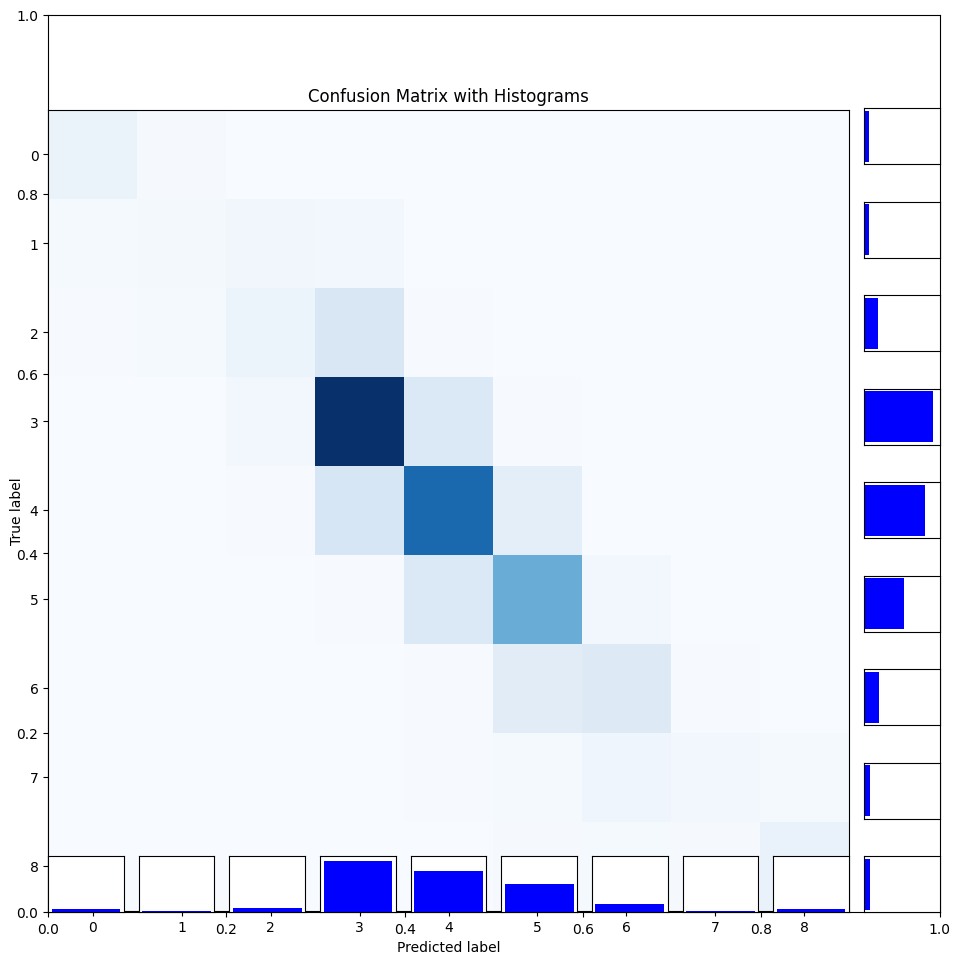

In [18]:
# Make predictions
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

print("Training Set Performance")
get_model_performance(Y_train, Y_pred_train)
print("---------------------------------------------")
print("Test Set Performance")
get_model_performance(Y_test, Y_pred_test)
print("--")


plot_confusion_matrix_with_histograms(Y_test, Y_pred_test)

In [19]:

feature_importances = model.feature_importances_

# Optionally, create a DataFrame to view feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


In [20]:
joblib.dump(model, model_folder / 'model.pkl')

significant_coefs_path = model_folder / "significant_coefs.csv"

feature_importance_df.to_csv(significant_coefs_path, index = False)
